# Object Detection with YOLOv8

## Installation
https://docs.ultralytics.com/quickstart/
 * pip install ultralytics

## Custom Dataset
학습을 위해서는 training, validation, testing으로 데이터를 분리해서 이미지와 라벨로 구성해야 합니다. 

이를 위해서 폴더 구성을 train, valid, test로 만들고 각각 폴더 아래에 images, labels라는 폴더를 만들고 이름을 공유하는 이미지와 라벨 파일을 넣어줍니다. (예, 1.png, 1.txt)

data.yaml 파일을 만들어서 폴더 구성과 클래스 갯수, 클래스 이름 정보를 넣어줍니다. 

```
train: /home/etri04/work/Pseudanabaena/train/images
val: /home/etri04/work/Pseudanabaena/valid/images
test: /home/etri04/work/Pseudanabaena/test/images

nc: 1
names: ['pseudanabaena']
```


In [1]:
%pylab inline
import os
import shutil
import random

import cv2
import yaml
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import math

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_nonzero_files(folder_path):
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            if os.path.isfile(file_path) and os.path.getsize(file_path) > 0:
                file_list.append(file_path)
    return file_list

## 학습을 위한 이미지 가공
Prediction 단계에서는 이미지의 크기는 무관하지만 학습을 위해서는 이미지 사이즈를 통일해야 한다. batch를 위해서는 이미지 사이즈가 같아야 합니다. 

In [16]:
image_files = get_nonzero_files('valid/images/')

In [4]:
for i in image_files:
    image = cv2.imread(i, cv2.IMREAD_ANYCOLOR)
    image =cv2.resize(image, (640,640))
    cv2.imwrite(i, image)

In [17]:
for i in image_files:
    image = cv2.imread(i, 0)
    # image =cv2.resize(image, (640,640))
    cv2.imwrite(i, image)

## Data Augumentation 
학습 데이터를 눌리기 위해서 간단한 데이터 어그멘테이션을 진행했습니다. 

이 데이터셋의 경우 회전에 대해서 안전하기 때문에 90도씩 회전하면서 학습에 사용할 이미지 데이터를 얻었습니다. 

이미지를 회전하면 annotation 정보도 회정해야 하기 때문에 아래 rotate_yolo_labels_90()함수를 사용해서 annotation 정보도 회전 시켜준다.

In [3]:
def rotate_yolo_labels_90(yolo_labels_path, img_width, img_height):
    with open(yolo_labels_path, "r") as f:
        lines = f.readlines()

    rotated_lines = []

    for line in lines:
        class_idx, x_center_norm, y_center_norm, width_norm, height_norm = map(float, line.split())
        class_idx = int(class_idx)

        # Convert normalized center coordinates to pixel coordinates
        x_center = x_center_norm * img_width
        y_center = y_center_norm * img_height

        # Compute new pixel coordinates for rotated bounding box
        x_new = y_center
        y_new = img_width - x_center
        width_new = height_norm * img_height
        height_new = width_norm * img_width

        # Convert new pixel coordinates back to normalized coordinates
        x_new_norm = x_new / img_height
        y_new_norm = y_new / img_width
        width_new_norm = width_new / img_height
        height_new_norm = height_new / img_width

        # Append rotated annotation to list of strings
        rotated_line = f"{class_idx} {x_new_norm:.6f} {y_new_norm:.6f} {width_new_norm:.6f} {height_new_norm:.6f}\n"
        rotated_lines.append(rotated_line)

    return rotated_lines

### 회전할 yolo dataset 정보
이미지와 라벨 파일을 하나의 튜플로 묶어서 사용한다

In [12]:
root = "./valid/"
i = os.listdir(root+"images/")
l = os.listdir(root+"labels/")

i.sort()
l.sort()
dataset = [(root + "images/" + a, root + "labels/" + b) for a,b in zip(i,l)]

동일한 경로와 이름을 사용하고 회전된 이미지와 라벨에는 r를 붙여 표시한다.

In [13]:
for i, l in dataset:
    img_name = "."+i.split('.')[1]+'r.png'
    label_name = "."+l.split('.')[1]+'r.txt'
    image = cv2.imread(i, cv2.IMREAD_ANYCOLOR)
    h, w, _ = image.shape
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cv2.imwrite(img_name, image)
    
    rl = rotate_yolo_labels_90(l, w, h)
    with open(label_name, 'w') as f:
        for item in rl:
            f.write(item)

In [ ]:
for i, l in dataset:
    img_name = "."+i.split('.')[1]+'color.png'
    label_name = "."+l.split('.')[1]+'color.txt'
    img = cv2.imread(i, cv2.IMREAD_ANYCOLOR)
    img[:,:,1][img[:,:,1] > 180] = img[:,:,1][img[:,:,1] > 180] - 40
    img[:,:,2][img[:,:,2] > 180] = img[:,:,2][img[:,:,2] > 180] - 90
    cv2.imwrite(img_name, img)
    shutil.copy(l, label_name)
    

In [ ]:
for i, l in dataset:
    if 'r' in i.split('/')[-1]:
        continue
    img_name = "."+i.split('.')[1]+'gray.png'
    label_name = "."+l.split('.')[1]+'gray.txt'
    
    # print(img_name, label_name)
    img = cv2.imread(i, 0)
    
    cv2.imwrite(img_name, img)
    shutil.copy(l, label_name)

In [29]:
for i, l in dataset:
    if 'r' in i.split('/')[-1]:
        continue
    img_name = "."+i.split('.')[1]+'color.png'
    label_name = "."+l.split('.')[1]+'color.txt'
    
    # print(img_name, label_name)
    img = cv2.imread(i, cv2.IMREAD_ANYCOLOR)
    img[:,:,1][img[:,:,1] > 180] = img[:,:,1][img[:,:,1] > 180] - 40
    img[:,:,2][img[:,:,2] > 180] = img[:,:,2][img[:,:,2] > 180] - 90
    cv2.imwrite(img_name, img)
    shutil.copy(l, label_name)

In [31]:
image = cv2.imread(dataset[0][0], cv2.IMREAD_ANYCOLOR)

In [59]:
def plot_yolo(img, label, r=None):
    header = ["classes", "x", "y", "width", "height"]
    df = pd.read_csv(label, sep=' ', header=None, names=header)    
    image = cv2.imread(img, cv2.IMREAD_ANYCOLOR)
    h, w, _ = image.shape
    df.x = (df.x * w)
    df.y = (df.y * h)
    df.width = (df.width *w)
    df.height = (df.height *h)
    if r == None:
        r = (0,len(df))
    for i in range(*r):
        image = cv2.rectangle(image, (int(df.x[i] - df.width[i]/2), int(df.y[i] - df.height[i]/2)), (int(df.x[i] + df.width[i]/2), int(df.y[i] + df.height[i]/2)),(255,0,0), 2, cv2.LINE_8)
    fig = plt.figure(figsize=(6,6))
    imshow(image)

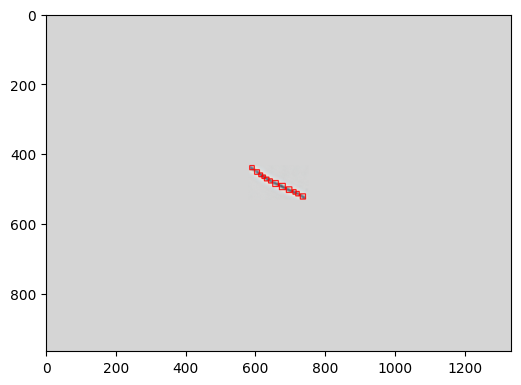

In [72]:
plot_yolo(*dataset[7])

## Reference
 * https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/
 * https://velog.io/@code_by_hot_pack/%ED%95%9C%EA%B8%80%ED%99%94-How-to-Train-YOLOv8-Object-Detection-on-a-Custom-Dataset